# evaluate the built model

In [1]:
%load_ext autoreload
%autoreload 2
from keras import applications, losses
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, Model, K
from keras.layers import Lambda, Input, Dropout, Flatten, Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, concatenate, GlobalAveragePooling2D, MaxPooling2D
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.metrics import top_k_categorical_accuracy
from keras.utils import Progbar, GeneratorEnqueuer
from keras.applications import imagenet_utils
import tensorflow as tf
import numpy as np
import os
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import inspect
import matplotlib.patches as patches

from utils import mkdirp, load_base, load_feature, anno_file_to_rect, anno_file_to_yolo_y, get_image_size, img2data

from yolo_data_generator import YoloDataGenerator
%matplotlib inline 

Using TensorFlow backend.


In [7]:
# build the feature data
train_data_dir = './dogs/images/train'
val_data_dir = './dogs/images/val'
round = .1
nb_train_samples = NB_TRAIN_SAMPLES = int(16494 * round // 1) ## copy from split script
nb_val_samples = NB_VAL_SAMPLES = int(4086 * round //1) ## copy from split script
epochs = 50
batch_size = 16
n_classes = 120
img_width, img_height = 224, 224

base_model_name = "mn"
GRIDS = {"inception": (5,5,2048), "mn": (7,7,1024)}
grid = GRIDS[base_model_name]

mkdirp(base_model_name)

In [8]:
images_root = "/Users/xuan/work/dataset/dogs/images"
annotations_root = "/Users/xuan/work/dataset/dogs/annotations"
train_images_root = images_root + "/train"
val_images_root = images_root + "/val"
train_annotations_root = annotations_root + "/train"
val_annotations_root = annotations_root + "/val"

In [10]:
feature_input = Input(shape=grid, name = 'feature_input')
x = feature_input
batch_size = 16
n_outputs = grid[0] * grid[1] * 5

x = Flatten()(x)
x = Dropout(0.8)(x)
x = Dense(n_outputs, activation='sigmoid', name='predictions')(x)

boxes_input = Input(shape=(n_outputs,), name = "box_input")

model = Model(input = feature_input, output = x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   (None, 7, 7, 1024)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50176)             0         
_________________________________________________________________
predictions (Dense)          (None, 245)               12293365  
Total params: 12,293,365
Trainable params: 12,293,365
Non-trainable params: 0
_________________________________________________________________


/Library/Python/2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("fe...)`
  if sys.path[0] == '':


In [11]:
mkdirp(base_model_name)
base_model, base_decoder, processor = load_base(base_model_name)

In [14]:
# build full model
weights = "/Users/xuan/work/ai-learn/yolo/" + "yolo-dogs-mn-6400125-11-76.48.hdf5"
model.load_weights(weights)
input = Input(shape=(img_width, img_height, 3), name = 'feature_input')
x = base_model(input)
x = model(x)
completed_model = Model(input=input, output=x)

/Library/Python/2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("mo..., inputs=Tensor("fe...)`
  import sys


In [15]:
train_generator = YoloDataGenerator(train_images_root, train_annotations_root)
val_generator = YoloDataGenerator(val_images_root, val_annotations_root)

In [16]:
def eval(completed_model = completed_model, val = True, JPEG_EXT = "JPEG", grid = (7,7)):
  batch_size = 4
  _, axs = plt.subplots(1, batch_size, figsize=(32, 32))
  for i in range(0, batch_size):
      ax = axs[i]
      ax.grid(b=None)
    
      total = len(val_generator.ids) if val else  len(train_generator.ids)
      sample = np.random.randint(0, total) if val else np.random.randint(0, total)
      generator = val_generator if val else train_generator
      image_file =  "{}/{}/{}.{}".format(images_root, "val" if val else "train", generator.ids[sample], JPEG_EXT)
      annotation_file = "{}/{}/{}".format(annotations_root ,"val" if val else "train", generator.ids[sample])

      (image_width, image_height) = get_image_size(annotation_file)

      ax.imshow(imread(image_file))

      rect = anno_file_to_rect(annotation_file)
      patch = patches.Rectangle((rect[0],rect[1]),rect[2] - rect[0],rect[3] - rect[1],linewidth=4,edgecolor='g',facecolor='none')
      ax.add_patch(patch)
      print "truth rect", rect

      # draw fitted model
      xs = img2data(image_file)
      # predict
      y_ = completed_model.predict(processor(xs), batch_size = 1)
      y_ = y_[0]
      cell = np.argmax(np.hstack(np.array([[1,0,0,0,0]] * (grid[0] * grid[1]))) * y_) / 5 
      print "confidences list as\n", np.round(100.0 * np.reshape(y_, (-1, grid[0], grid[1], 5))[..., 0]) / 100.0
      cell_x = cell % grid[1]
      cell_y = cell // grid[0]
      base = cell * 5
      gx = grid[0]
      gy = grid[1]
      cell_width = float(image_width) / gx
      cell_height = float(image_height) / gy

      (C, cx, cy, w, h) = y_[base: base + 5]
#       print "Max Confidence cx, cy, w, h", y_[base: base + 5]

      rect = np.array([(cell_x + cx - w * gx / 2.0 ) * cell_width, 
                (cell_y + cy - h * gy / 2.0 ) * cell_height, 
                w * image_width, 
                h * image_height])
#       print "rect", (rect[0], rect[1]), rect[2], rect[3]

      patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2,edgecolor='r',facecolor='none')
      ax.add_patch(patch)
      center_x = (cell_x + cx) * cell_width
      center_y = (cell_y + cy) * cell_height

      # print center point
#       print "center x & y", center_x, center_y
      patch = patches.Circle((center_x, center_y), 6, linewidth=1,color='r',fill='full')
      ax.add_patch(patch)

      #draw center rect
      rect = (cell_x * cell_width, cell_y * cell_height, cell_width, cell_height)
      print "center cell", rect
      patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2,edgecolor='r',facecolor='none')
#       ax.add_patch(patch)
  
  plt.show()

eval some train data
truth rect (0, 12, 267, 424)


/Library/Python/2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


confidences list as
[[[ 0.          0.          0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.86000001  0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.          0.          0.        ]]]
center cell (128.57142857142856, 182.57142857142856, 42.857142857142854, 60.857142857142854)
truth rect (9, 41, 200, 270)
confidences list as
[[[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  

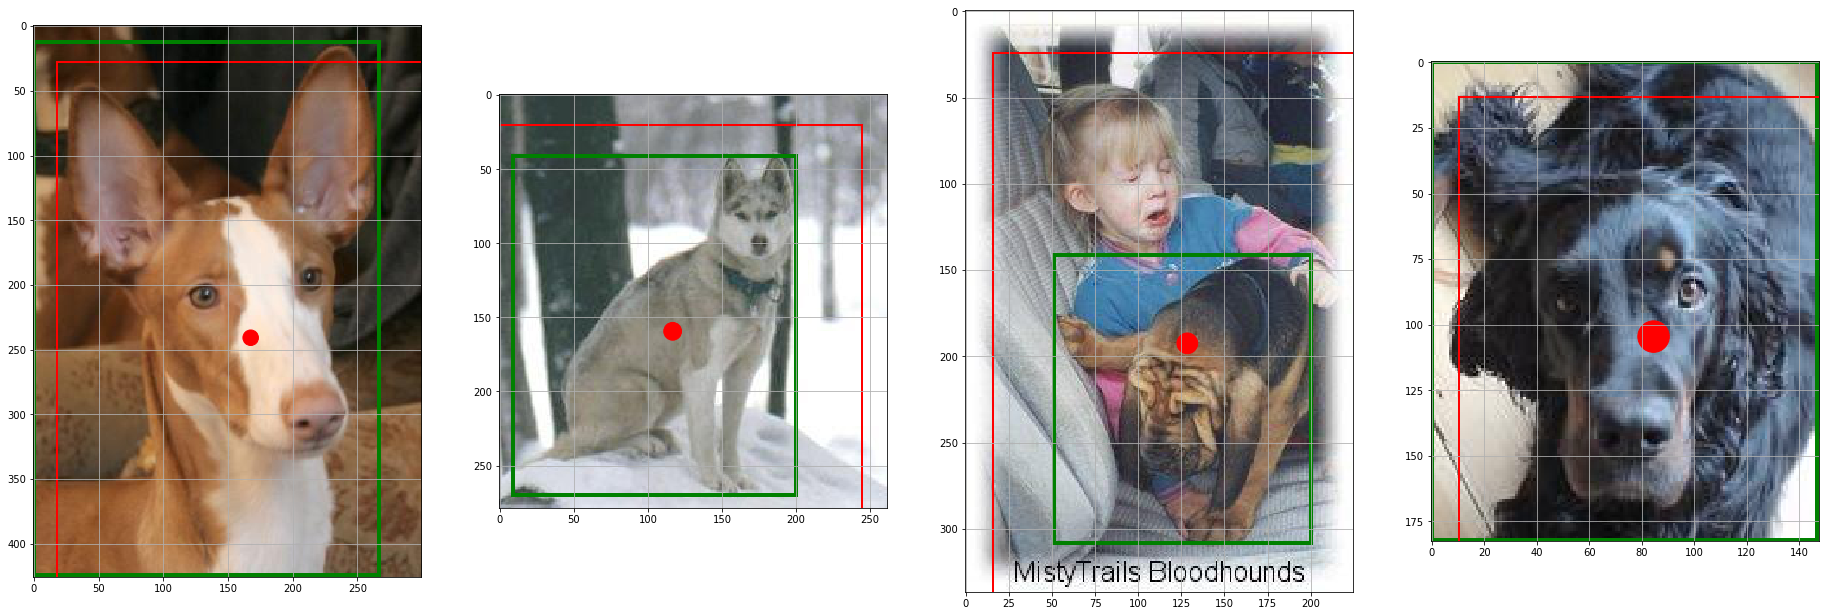

In [18]:
print "eval some train data"
eval(val=False)